In [1]:
import os
import six.moves.cPickle as pickle
import gzip
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.nnet import conv2d, conv2d_transpose
from theano.tensor.signal import pool
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'
theano.config.compute_test_value = 'off'
theano.config.floatX = 'float32'
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [2]:
# create shared variables for using gpu
def shared_dataset(data, borrow=True, data_types=['float32','int32']):
    if type(data) is not list:
        data = list(data)
    output = []
    for i, x in enumerate(data):
        output.append(theano.shared(np.asarray(x, dtype=data_types[i]), borrow=borrow))
    return output

def load_dataset(dataset):
    # get path/file for dataset
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the current directory.
        new_path = os.path.join(os.curdir, dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path
    # download from website
    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)
    # load from pickle
    print('... loading data')
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # set test/valid/train sets
    test_set_x, test_set_y = shared_dataset(test_set)
    valid_set_x, valid_set_y = shared_dataset(valid_set)
    train_set_x, train_set_y = shared_dataset(train_set)
    # combine datasets
    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y), (test_set_x, test_set_y)]
    return rval

In [538]:
class HelmholtzLayer(object):
    '''WRITEME'''
    def __init__(self, input, n_in, n_out, th_rng=None, top_layer=False):
        # init vars
        self.input = input
        self.n_in = n_in
        self.n_out = n_out
        # init th_rng if None
        if th_rng is None:
            self.th_rng = RandomStreams(1)
        else:
            self.th_rng = th_rng
        self.top_layer = top_layer
        
        # recognition weights
        self.WR = theano.shared(np.zeros((n_in,n_out), dtype=theano.config.floatX),
                                borrow=True, name='WR')
        # recognition biases
        self.bR = theano.shared(np.zeros((n_out,), dtype=theano.config.floatX), 
                                borrow=True, name='bR')
        # generative weights
        self.WG = theano.shared(np.zeros((n_out,n_in), dtype=theano.config.floatX),
                                borrow=True, name='WG')
        # generative biases
        self.bG = theano.shared(np.zeros((n_in,), dtype=theano.config.floatX),
                                borrow=True, name='bG')
        
        # if top_layer, remove shared WR, bR, WG
        if self.top_layer:
            self.WR = T.zeros_like(self.WR)
            self.bR = T.zeros_like(self.bR)
            self.WG = T.zeros_like(self.WG)
            # set gen_params, rec_params
            self.gen_params = [self.bG]
            self.rec_params = []
        else:
            # set gen_params, rec_params
            self.gen_params = [self.WG, self.bG]
            self.rec_params = [self.WR, self.bR]
        
        # set output
        self.output = self.sample_h_given_v(self.input)
        
        # init reconstr, top_down, p to None
        self.reconstr = None
        self.top_down = None
        
    def propup(self, v):
        return T.nnet.sigmoid(T.dot(v, self.WR) + self.bR)
    
    def propdown(self, h):
        return T.nnet.sigmoid(T.dot(h, self.WG) + self.bG)
    
    def sample_h_given_v(self, v):
        h = self.propup(v)
        return self.th_rng.binomial(size=h.shape, n=1, p=h, dtype=theano.config.floatX)
    
    def sample_v_given_h(self, h):
        v = self.propdown(h)
        return self.th_rng.binomial(size=v.shape, n=1, p=v, dtype=theano.config.floatX)
    
    def get_wake_derivs(self):
        '''WRITEME'''
        # get delta by propagating down with output
        delta = self.propdown(self.output)
        
        # get wake derivatives
        dWG = T.dot(self.output.T, (self.input - delta))
        dbG = T.mean((self.input - delta), axis=0)
        
        # if top_layer, no WG derivs
        if self.top_layer:
            return [dbG]
        else:
            return dWG, dbG
    
    def get_sleep_derivs(self):
        '''WRITEME'''
        # if top_layer, no sleep derivs
        if self.top_layer:
            return []
        
        # get psi by propagating up with reconstr
        psi = self.propup(self.reconstr)
        
        # get sleep derivatives
        dWR = T.dot(self.reconstr.T, (self.top_down - psi))
        dbR = T.mean((self.top_down - psi), axis=0)
        return dWR, dbR
        
    def set_reconstr(self, top_down):
        self.top_down = top_down
        self.reconstr = self.sample_v_given_h(self.top_down)

In [546]:
class HelmholtzMachine(object):
    '''WRITEME'''
    def __init__(self, n_layers, n_ins, th_rng=None):
        # init vars
        self.n_layers = n_layers
        self.n_ins = n_ins
        if th_rng is None:
            self.th_rng = RandomStreams(np.random.randint(2**30))
        else:
            self.th_rng = th_rng
            
        # init first layer input variable
        self.v = T.matrix('v')
        
        # for each layer, append HelmholtzLayer
        self.helmholtz_layers = []
        for n in range(self.n_layers):
            # set bG_1 to True if top layer, False otherwise
            is_top_layer = (n == self.n_layers - 1)
            # set input_layer
            if n == 0:
                input_layer = self.v
            else:
                input_layer = self.helmholtz_layers[-1].output
            # set n_out
            if is_top_layer:
                n_out = 1
            else:
                n_out = self.n_ins[n+1]
            # create helmholtz layer
            self.helmholtz_layers.append(HelmholtzLayer(input_layer, 
                                                         self.n_ins[n], 
                                                         n_out,
                                                         th_rng=self.th_rng,
                                                         top_layer=is_top_layer))
            
        # for each layer, set reconstr
        for n in range(self.n_layers-1, -1, -1):
            # for top layer, top_down is zeros
            if n == self.n_layers-1:
                top_down = T.zeros((1,1), dtype=theano.config.floatX)
            else:
                top_down = self.helmholtz_layers[n+1].reconstr
            # set top_down and reconstr
            self.helmholtz_layers[n].set_reconstr(top_down)
    
    def model_sample(self):
        return self.helmholtz_layers[0].reconstr[0]
    
    def KL_part(self, d, D, M):
        d0 = 1. - d
        D0 = 1. - D
        M0 = 1. - M
        p_d = T.mean(T.eq(T.dot(d, D.T), T.dot(d, d.T)) * T.eq(T.dot(d0, D0.T), T.dot(d0, d0.T)))
        p_m = T.mean(T.eq(T.dot(d, M.T), T.dot(d, d.T)) * T.eq(T.dot(d0, M0.T), T.dot(d0, d0.T)))
        return T.mul(p_d, T.sub(T.log(p_d), T.log(p_m + 1e-6)))
    
    def KL(self):
        D = T.matrix('D')
        # get model samples
        M,_ = theano.scan(self.model_sample, n_steps=D.shape[0])
        # get unique probabilities of each data vector
        KLs, _ = theano.scan(self.KL_part, sequences=[D], non_sequences=[D, M])
        KLs = T.extra_ops.Unique(True)(KLs)[0]
        return theano.function([D], T.sum(KLs))
    
    def MSE(self):
        D = T.matrix('D')
        M,_ = theano.scan(self.model_sample, n_steps=D.shape[0])
        return theano.function([D], T.mean(T.square(D - M)))
    
    def free_energy_part(self, n):
        q = self.helmholtz_layers[n].propup(self.helmholtz_layers[n].input)
        p = self.helmholtz_layers[n+1].propdown(self.helmholtz_layers[n+1].output)
        return T.sum(T.add(T.mul(q, T.log(q + 1e-6) - T.log(p + 1e-6)),
                           T.mul((1. - q), T.log(1. - q + 1e-6) - T.log(1. - p + 1e-6))))
    
    def free_energy(self):
        FEs = []
        # for layer 0, q is data, p are reconstructions
        q = T.matrix('q')
        p = self.helmholtz_layers[0].propdown(self.helmholtz_layers[0].output)
        # compute FE part for layer 0
        FEs.append(T.sum(T.add(T.mul(q, T.log(q + 1e-6) - T.log(p + 1e-6)),
                               T.mul((1. - q), T.log(1. - q + 1e-6) - T.log(1. - p + 1e-6)))))
        # compute for all other layers (except top layer)
        for n in range(self.n_layers-1):
            FEs.append(self.free_energy_part(n))
        # return function that can compute FE for given data
        return theano.function([q], T.sum(FEs), givens={self.v: q})
    
    def train_function(self, train_data, batch_size, cost_type='free_energy'):
        # init vars
        awake = T.iscalar('awake').astype(theano.config.floatX)
        lr = [T.scalar('lr_' + str(n)) for n in range(self.n_layers)]
        idx = T.iscalar('idx')
        v = train_data[idx * batch_size:(idx + 1) * batch_size]  
            
        # parameter updates for theano function
        updates = []
        for n in range(self.n_layers):
            # wake phase
            wake_derivs = self.helmholtz_layers[n].get_wake_derivs()
            for param, gparam in zip(self.helmholtz_layers[n].gen_params, wake_derivs):
                updates.append((param, param + awake * lr[n] * gparam))
            # sleep phase
            sleep_derivs = self.helmholtz_layers[n].get_sleep_derivs()
            for param, gparam in zip(self.helmholtz_layers[n].rec_params, sleep_derivs):
                updates.append((param, param + (1. - awake) * lr[n] * gparam))
        
        # create train_fn
        inputs = [idx, awake] + lr
        train_fn = theano.function(inputs, [], updates=updates, givens={self.v: v})
        
        # set cost_fn
        if cost_type == 'KL':
            cost_fn = self.KL()
        elif cost_type == 'MSE':
            cost_fn = self.MSE()
        elif cost_type == 'free_energy':
            cost_fn = self.free_energy()
        else:
            cost_fn = None
            
        return train_fn, cost_fn

In [544]:
data = load_dataset('mnist.pkl.gz')[0][0]

... loading data


In [532]:
# create bar data
data = np.zeros((1000, 3, 3), dtype=theano.config.floatX)
for n in range(data.shape[0]):
    # Horizontal bars 1/3, vertical bars 2/3
    if np.random.rand() > (2./3.): 
        data[n, np.random.randint(data.shape[1]), :] = 1.
    else:
        data[n, :, np.random.randint(data.shape[2])] = 1.
data = np.reshape(data, (data.shape[0], -1))
data = T.as_tensor(data)

In [561]:
# initialize helmholtz machine
# th_rng = RandomStreams(1)
helm = HelmholtzMachine(3, [784, 512, 128]) #[9,6,1]) # 
# create training function
batch_size = 1
train_fn, cost_fn = helm.train_function(data, batch_size, cost_type='free_energy')

'Epoch 0 (30.00%): 1176216.5000'

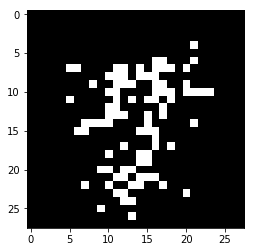

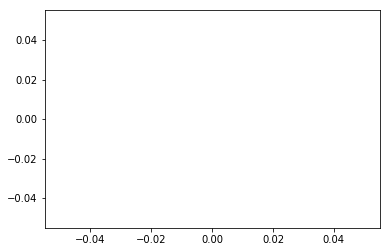

KeyboardInterrupt: 

In [562]:
# train
lr = [0.001]*helm.n_layers
n_batches = data.eval().shape[0]//batch_size
monitor = data.eval().shape[0]//10
cost_history = []
im_size = (28,28)

# train in epochs
for epoch in range(50):
    cost = []
    # for each batch_size within n_batches, train
    for n in range(n_batches):
        train_fn(n, True, *lr) # wake phase
        train_fn(n, False, *lr) # sleep phase
        
        # monitor samples
        if n % monitor == 0:
            # get cost
            rand_idxs = np.random.permutation(data.eval().shape[0])
            cost.append(cost_fn(data[rand_idxs[:monitor]].eval()))
            # print progress
            clear_output(wait=True)
            display('Epoch %d (%0.2f%%): %0.4f' % (epoch, 100. * n/n_batches, np.mean(cost)))
            # plot sample from model
            plt.imshow(helm.model_sample().eval().reshape(im_size), cmap='gray')
            plt.show()
            # plot cost history
            plt.plot(cost_history)
            plt.show()
    # append cost history
    cost_history.append(np.mean(cost))

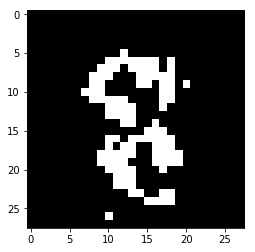

In [376]:
plt.imshow(helm.model_sample().eval().reshape(im_size), cmap='gray')
plt.show()